#### Calculate elevation change by the generated aster dems.

In [14]:
import os
import matplotlib.pyplot as plt
from utils.geotif_io import readTiff
import numpy as np
from utils.crop_to_extent import crop_to_extent


### Multiply-tile dems for one specific year.

In [18]:
year='2006'
path_dem_1 = 'data/aster-stereo/SETP-'+year+'/tiles-dem/tile-28-96/dems_mosaic_subs.tif'
path_dem_2 = 'data/aster-stereo/SETP-'+year+'/tiles-dem/tile-29-92/dems_mosaic_subs.tif'
path_dem_3 = 'data/aster-stereo/SETP-'+year+'/tiles-dem/tile-30-93/dems_mosaic_subs.tif'
path_dem_4 = 'data/aster-stereo/SETP-'+year+'/tiles-dem/tile-31-92/dems_mosaic_subs.tif'


In [19]:
if os.path.exists(path_dem_1):
  dem_1, dem_info = readTiff(path_dem_1)
else: dem_1 = np.zeros((3000, 3000))
if os.path.exists(path_dem_2):
  dem_2, dem_info = readTiff(path_dem_2)
else: dem_2 = np.zeros((3000, 3000))
if os.path.exists(path_dem_3):
  dem_3, dem_info = readTiff(path_dem_3)
else: dem_3 = np.zeros((3000, 3000))
if os.path.exists(path_dem_4):
  dem_4, dem_info = readTiff(path_dem_4)
else: dem_4 = np.zeros((3000, 3000))


Text(0.5, 1.0, 'dem 4')

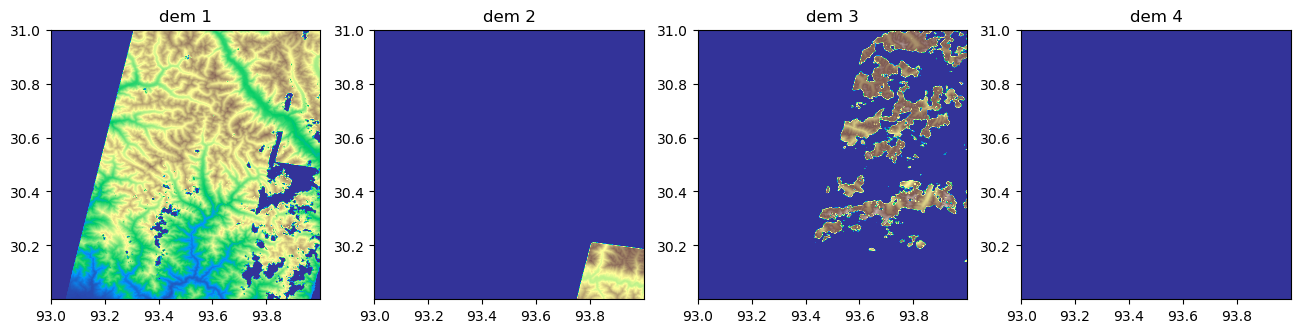

In [21]:
plt.figure(figsize=(16,8))
plt.subplot(1,4,1)
plt.imshow(dem_1, vmin=0, vmax=7000, extent=dem_info['geoextent'], cmap='terrain')
plt.title('dem 1')
plt.subplot(1,4,2)
plt.imshow(dem_2, vmin=0, vmax=7000, extent=dem_info['geoextent'], cmap='terrain')
plt.title('dem 2')
plt.subplot(1,4,3)
plt.imshow(dem_3, vmin=0, vmax=7000, extent=dem_info['geoextent'], cmap='terrain')
plt.title('dem 3')
plt.subplot(1,4,4)
plt.imshow(dem_4, vmin=0, vmax=7000, extent=dem_info['geoextent'], cmap='terrain')
plt.title('dem 4')


### Multiple-year dems in one specific tile


In [23]:
bottom, left = 30, 93
tile_dir = 'tile-'+str(bottom)+'-'+str(left)


In [27]:
path_srtm = 'data/dem-data/srtm-c/tiles/tile_'+str(bottom)+'_'+str(left)+'.tif'
path_mask_glacier = 'data/rgi60/tiles/tile_'+str(bottom)+'_'+str(left)+'.tif'
path_dem_2006 = 'data/aster-stereo/SETP-2006/tiles-dem/' + tile_dir + '/dems_mosaic_subs.tif'
path_dem_2007 = 'data/aster-stereo/SETP-2007/tiles-dem/' + tile_dir + '/dems_mosaic_subs.tif'
path_dem_2008 = 'data/aster-stereo/SETP-2008/tiles-dem/' + tile_dir + '/dems_mosaic_subs.tif'
path_dem_2009 = 'data/aster-stereo/SETP-2009/tiles-dem/' + tile_dir + '/dems_mosaic_subs.tif'


In [28]:
srtm, srtm_info = readTiff(path_srtm)
mask_glacier = crop_to_extent(path_img=path_mask_glacier, extent=srtm_info['geoextent'], size_target=srtm.shape) # read and resize
mask_glacier[mask_glacier<0]=0; mask_glacier = np.int8(mask_glacier)
if os.path.exists(path_dem_2006):
  dem_2006 = crop_to_extent(path_img=path_dem_2006, extent=srtm_info['geoextent'], size_target=srtm.shape) # read and resize
else: dem_2006 = np.zeros_like(srtm)
if os.path.exists(path_dem_2007):
  dem_2007 = crop_to_extent(path_img=path_dem_2007, extent=srtm_info['geoextent'], size_target=srtm.shape) # read and resize
else: dem_2007 = np.zeros_like(srtm)
if os.path.exists(path_dem_2008):
  dem_2008 = crop_to_extent(path_img=path_dem_2008, extent=srtm_info['geoextent'], size_target=srtm.shape) # read and resize
else: dem_2008 = np.zeros_like(srtm)
if os.path.exists(path_dem_2009):
  dem_2009 = crop_to_extent(path_img=path_dem_2009, extent=srtm_info['geoextent'], size_target=srtm.shape) # read and resize
else: dem_2009 = np.zeros_like(srtm)


Text(0.5, 1.0, 'aster dem 2009')

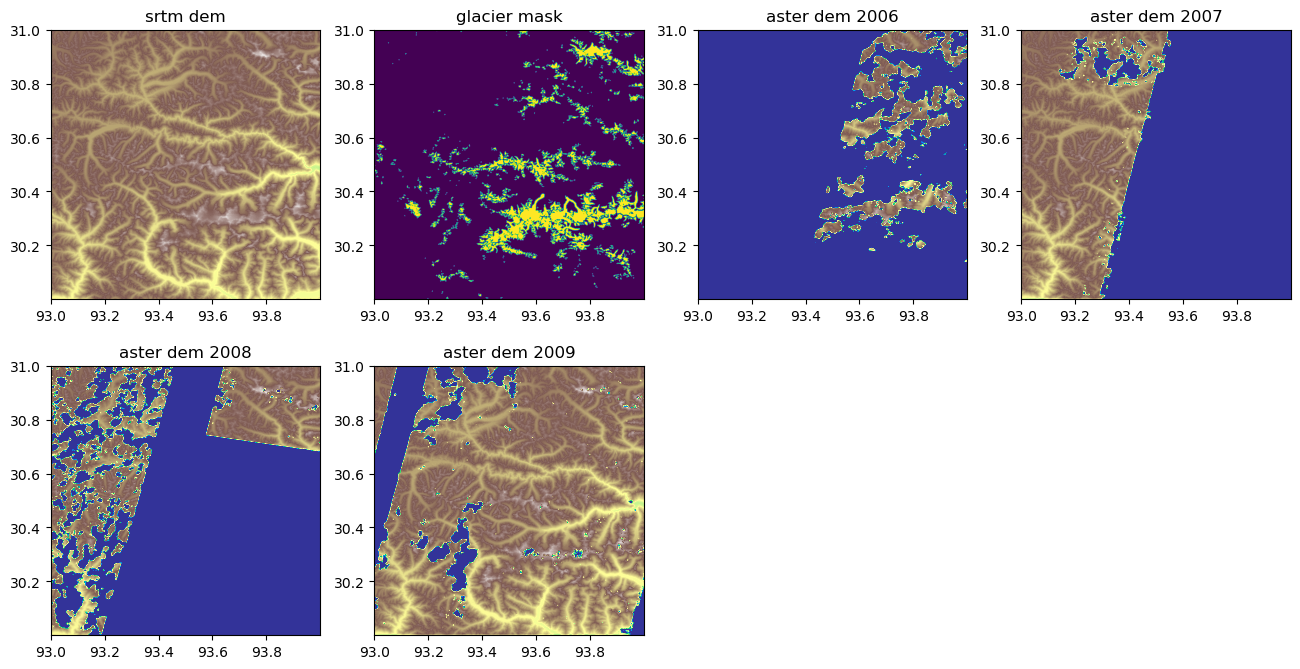

In [29]:
plt.figure(figsize=(16,8))
plt.subplot(2,4,1)
plt.imshow(srtm, vmin=0, vmax=7000, extent=srtm_info['geoextent'], cmap='terrain')
plt.title('srtm dem')
plt.subplot(2,4,2)
plt.imshow(mask_glacier, vmin=0, vmax=1, extent=srtm_info['geoextent'])
plt.title('glacier mask')
plt.subplot(2,4,3)
plt.imshow(dem_2006, vmin=0, vmax=7000, extent=srtm_info['geoextent'], cmap='terrain')
plt.title('aster dem 2006')
plt.subplot(2,4,4)
plt.imshow(dem_2007, vmin=0, vmax=7000, extent=srtm_info['geoextent'], cmap='terrain')
plt.title('aster dem 2007')
plt.subplot(2,4,5)
plt.imshow(dem_2008, vmin=0, vmax=7000, extent=srtm_info['geoextent'], cmap='terrain')
plt.title('aster dem 2008')
plt.subplot(2,4,6)
plt.imshow(dem_2009, vmin=0, vmax=7000, extent=srtm_info['geoextent'], cmap='terrain')
plt.title('aster dem 2009')


In [30]:
dif_2007 = srtm - dem_2007
dif_2008 = srtm - dem_2008
dif = dem_2007 - dem_2008


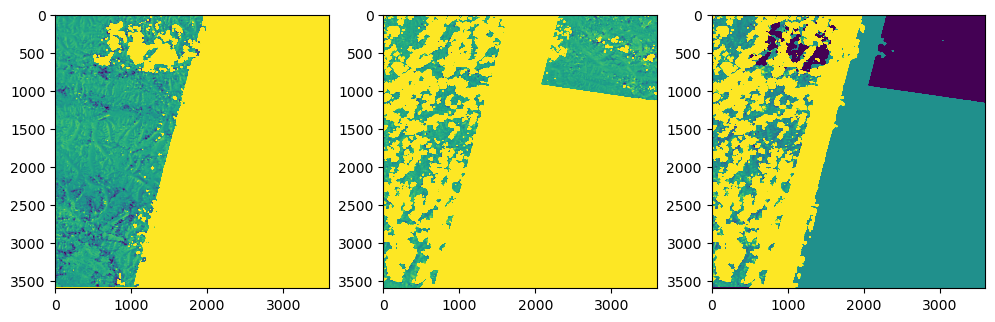

In [31]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(dif_2007, vmax=100, vmin=-100)
plt.subplot(1,3,2)
plt.imshow(dif_2008, vmax=100, vmin=-100)
plt.subplot(1,3,3)
plt.imshow(dif, vmax=100, vmin=-100)

